In [1]:
import time
import yaml
import torch

import scipy.sparse as sp
import numpy as np
import seaborn as sns
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch.optim import Adam, Optimizer
from collections import defaultdict
from torch_geometric.data import Data, InMemoryDataset

from data import get_dataset, HeatDataset, PPRDataset, set_train_val_test_split
from models import GCN
from seeds import val_seeds, test_seeds

# GCN with GDC
This notebook demonstrates how to enhance GCN with GDC.

## GDC
At its core, preprocessing with GDC is just this function.

In [2]:
def gdc(A: sp.csr_matrix, alpha: float, eps: float):
    N = A.shape[0]

    # Self-loops
    A_loop = sp.eye(N) + A

    # Symmetric transition matrix
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

    # PPR-based diffusion
    S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)

    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)

    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / D_tilde_vec
    
    return T_S

## Choose backend
We will use the GPU in this notebook. If you want to use a CPU instead simply change this line to `cpu`.

In [3]:
device = 'cuda'

## Load configuration
The parameter settings for datasets and models as well as the training routine are stored in `config.yaml`.

In [4]:
with open('config.yaml', 'r') as c:
    config = yaml.safe_load(c)

## Load dataset and preprocess with GDC
For convenience we will use a PyTorch Geometric InMemoryDataset in this notebook. `PPRDataset` (and `HeatDataset`) provide more flexibility and functionality than the above `gdc` method. However, their preprocessing is essentially the same.

In [9]:
datasets = {}

kernels = ['SCCT_H','CCT_H','katz','Comm','CT_H','For_H','NHeat_H','SCT_H','ModifPPR_H','HeatPR','Abs']
dataset_name = 'Cora'
for preprocessing in ['none', 'heat', 'ppr']:
    if preprocessing == 'none':
        dataset = get_dataset(
            name=dataset_name,
            use_lcc=config['use_lcc']
        )
        dataset.data = dataset.data.to(device)
        datasets[preprocessing] = dataset
    elif preprocessing == 'heat':
        dataset = HeatDataset(
            name=dataset_name,
            use_lcc=config['use_lcc'],
            t=config[preprocessing]['t'],
            k=config[preprocessing]['k'],
            eps=config[preprocessing]['eps'],
            kernel = 'heat'
        )
        dataset.data = dataset.data.to(device)
        datasets[preprocessing] = dataset
    elif preprocessing == 'ppr':
        dataset = PPRDataset(
            name=dataset_name,
            use_lcc=config['use_lcc'],
            alpha=config[preprocessing]['alpha'],
            k=config[preprocessing]['k'],
            eps=config[preprocessing]['eps']
        )
        dataset.data = dataset.data.to(device)
        datasets[preprocessing] = dataset

for kernel in kernels:
    dataset = HeatDataset(
            name=dataset_name,
            use_lcc=config['use_lcc'],
            t=config['heat']['t'],
            k=config['heat']['k'],
            eps=config['heat']['eps'],
            kernel = kernel
        )
    dataset.data = dataset.data.to(device)
    datasets[kernel] = dataset
        

## Create GCN models

In [22]:
models = {}

for preprocessing, dataset in datasets.items():
    if preprocessing in ['none', 'ppr']:
        models[preprocessing] = GCN(
            dataset,
            hidden=config[preprocessing]['hidden_layers'] * [config[preprocessing]['hidden_units']],
            dropout=config[preprocessing]['dropout']
        ).to(device)
    else:
        models[preprocessing] = GCN(
            dataset,
            hidden=config['heat']['hidden_layers'] * [config['heat']['hidden_units']],
            dropout=config['heat']['dropout']
        ).to(device)

## Train model

In [24]:
def train(model: torch.nn.Module, optimizer: Optimizer, data: Data):
    model.train()
    optimizer.zero_grad()
    logits = model(data)
    loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [25]:
def evaluate(model: torch.nn.Module, data: Data, test: bool):
    model.eval()
    with torch.no_grad():
        logits = model(data)
    eval_dict = {}
    keys = ['val', 'test'] if test else ['val']
    for key in keys:
        mask = data[f'{key}_mask']
        # loss = F.nll_loss(logits[mask], data.y[mask]).item()
        # eval_dict[f'{key}_loss'] = loss
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        eval_dict[f'{key}_acc'] = acc
    return eval_dict

In [ ]:
def run(dataset: InMemoryDataset,
        model: torch.nn.Module,
        seeds: np.ndarray,
        test: bool = False,
        max_epochs: int = 10000,
        patience: int = 100,
        lr: float = 0.01,
        weight_decay: float = 0.01,
        num_development: int = 1500,
        device: str = 'cuda'):
    start_time = time.perf_counter()

    best_dict = defaultdict(list)

    cnt = 0
    for seed in tqdm(seeds):
        dataset.data = set_train_val_test_split(
            seed,
            dataset.data,
            num_development=num_development,
        ).to(device)
        model.to(device).reset_parameters()
        optimizer = Adam(
            [
                {'params': model.non_reg_params, 'weight_decay': 0},
                {'params': model.reg_params, 'weight_decay': weight_decay}
            ],
            lr=lr
        )

        patience_counter = 0
        tmp_dict = {'val_acc': 0}

        for epoch in range(1, max_epochs + 1):
            if patience_counter == patience:
                break

            train(model, optimizer, dataset.data)
            eval_dict = evaluate(model, dataset.data, test)

            if eval_dict['val_acc'] < tmp_dict['val_acc']:
                patience_counter += 1
            else:
                patience_counter = 0
                tmp_dict['epoch'] = epoch
                for k, v in eval_dict.items():
                    tmp_dict[k] = v

        for k, v in tmp_dict.items():
            best_dict[k].append(v)
            
    best_dict['duration'] = time.perf_counter() - start_time
    return dict(best_dict)

We are training the models 100 times on different splits, so this will take a couple of minutes.

In [16]:
results = {}

for preprocessing in ['none','heat','ppr']:
# for preprocessing in ['heat']:
    results[preprocessing] = run(
        datasets[preprocessing],
        models[preprocessing],
        seeds=test_seeds if config['test'] else val_seeds,
        lr=config[preprocessing]['lr'],
        weight_decay=config[preprocessing]['weight_decay'],
        test=config['test'],
        num_development=config['num_development'],
        device=device
    )

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
for preprocessing in kernels:
# for preprocessing in ['heat']:
    results[preprocessing] = run(
        datasets[preprocessing],
        models[preprocessing],
        seeds=test_seeds[:20] if config['test'] else val_seeds,
        lr=config['heat']['lr'],
        weight_decay=config['heat']['weight_decay'],
        test=config['test'],
        num_development=config['num_development'],
        device=device
    )
    mean_acc = results[preprocessing]['test_acc']
    print(f"{preprocessing}: Mean accuracy: {100 * np.mean(mean_acc):.2f} +- {100 * np.std(mean_acc):.2f}%")


  0%|          | 0/20 [00:00<?, ?it/s]

SCCT_H: Mean accuracy: 82.60 +- 0.82%


  0%|          | 0/20 [00:00<?, ?it/s]

CCT_H: Mean accuracy: 82.59 +- 1.24%


  0%|          | 0/20 [00:00<?, ?it/s]

katz: Mean accuracy: 82.64 +- 1.21%


  0%|          | 0/20 [00:00<?, ?it/s]

Comm: Mean accuracy: 82.84 +- 1.04%


  0%|          | 0/20 [00:00<?, ?it/s]

CT_H: Mean accuracy: 82.53 +- 1.16%


  0%|          | 0/20 [00:00<?, ?it/s]

For_H: Mean accuracy: 82.58 +- 1.21%


  0%|          | 0/20 [00:00<?, ?it/s]

NHeat_H: Mean accuracy: 82.48 +- 1.18%


  0%|          | 0/20 [00:00<?, ?it/s]

SCT_H: Mean accuracy: 82.52 +- 0.99%


  0%|          | 0/20 [00:00<?, ?it/s]

ModifPPR_H: Mean accuracy: 82.83 +- 1.11%


  0%|          | 0/20 [00:00<?, ?it/s]

HeatPR: Mean accuracy: 82.68 +- 1.09%


  0%|          | 0/20 [00:00<?, ?it/s]

Abs: Mean accuracy: 82.39 +- 0.96%


## Evaluate result

Calculate statistics using bootstrapping.

# Cora

In [53]:
# Abs
results_plot = {}
for preprocessing in ['none','heat','ppr']:
    mean_acc = results[preprocessing]['test_acc']
    uncertainty = results[preprocessing]['test_acc_ci']
    print(f"{preprocessing}: Mean accuracy: {100 * mean_acc:.2f} +- {100 * uncertainty:.2f}%")
    results_plot[preprocessing] = 100 * mean_acc
for preprocessing in kernels:
    mean_acc = results[preprocessing]['test_acc']
#     uncertainty = results[preprocessing]['test_acc_ci']
    results_plot[preprocessing] = 100 * np.mean(mean_acc)
    print(f"{preprocessing}: Mean accuracy: {100 * np.mean(mean_acc):.2f} +- {100 * np.std(mean_acc):.2f}%")


none: Mean accuracy: 81.75 +- 0.25%
heat: Mean accuracy: 83.18 +- 0.21%
ppr: Mean accuracy: 83.20 +- 0.21%
SCCT_H: Mean accuracy: 82.60 +- 0.82%
CCT_H: Mean accuracy: 82.59 +- 1.24%
katz: Mean accuracy: 82.64 +- 1.21%
Comm: Mean accuracy: 82.84 +- 1.04%
CT_H: Mean accuracy: 82.53 +- 1.16%
For_H: Mean accuracy: 82.58 +- 1.21%
NHeat_H: Mean accuracy: 82.48 +- 1.18%
SCT_H: Mean accuracy: 82.52 +- 0.99%
ModifPPR_H: Mean accuracy: 82.83 +- 1.11%
HeatPR: Mean accuracy: 82.68 +- 1.09%
Abs: Mean accuracy: 82.39 +- 0.96%


In [62]:
df = pd.DataFrame(results_plot.items(), columns=['Kernel', 'Accuracy'])

In [63]:
import matplotlib 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

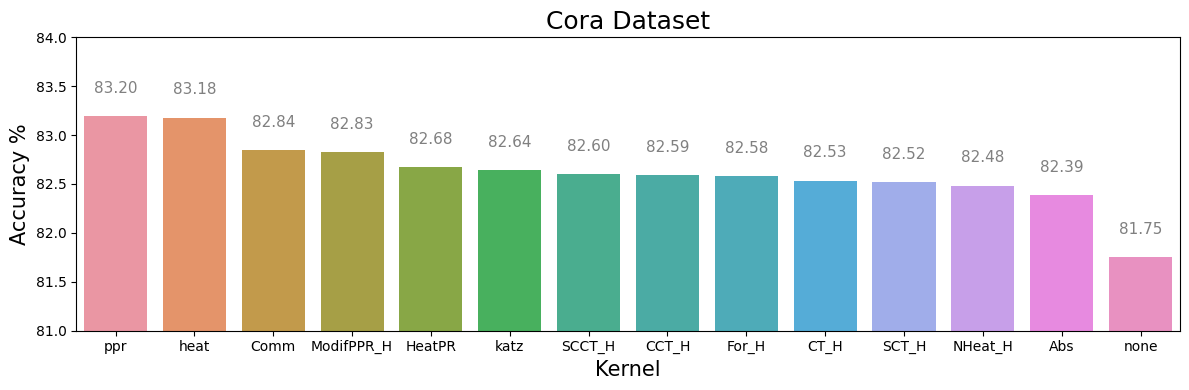

In [81]:
plt.figure(figsize=(12,4))
# make barplot and sort bars in descending order
g = sns.barplot(x='Kernel', 
            y="Accuracy", 
            data=df, 
            order=df.sort_values('Accuracy',ascending = False).Kernel)
# set labels
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                textcoords='offset points')
_ = g.set_ylim(0,120) #To make space for the annotations

plt.ylabel("Accuracy %", size=15)
plt.xlabel("Kernel", size=15)
plt.title("Cora Dataset", size=18)
plt.ylim(81, 84)
plt.tight_layout()
plt.savefig("/home/assem/gdc/Cora.png", dpi=100)
plt.show()
